### Image classfication on fashion MNIST or CIFAR-10

## Why Use Larger Datasets?

Larger datasets like CIFAR-10 or Fashion MNIST present more realistic and diverse challenges compared to toy datasets such as MNIST. They contain a greater variety of images, backgrounds, and object classes, making them better benchmarks for evaluating model performance in real-world scenarios. These datasets require deeper architectures, careful regularization, and data augmentation for optimal performance.

---

### Key Techniques to Improve Performance

#### Architectural Modifications
- **Increase Depth:** Add more convolutional layers to enable the model to learn hierarchical and complex features.
- **Vary Kernel Sizes:** Experiment with different kernel sizes to capture features at multiple scales.
- **More Filters:** Use more filters in deeper layers to capture intricate patterns and details.
- **Residual Connections:** Incorporate skip connections (as in ResNet) to help train deeper networks.

#### Regularization
- **Dropout:** Apply dropout in dense layers to reduce overfitting by randomly deactivating neurons during training.
- **Batch Normalization:** Use batch normalization in convolutional layers to stabilize and accelerate training.
- **Weight Decay:** Apply L2 regularization to penalize large weights and encourage simpler models.

#### Data Augmentation
- **Random Flipping:** Horizontally flip images to increase dataset diversity.
- **Random Cropping:** Crop images randomly to help the model become invariant to object position.
- **Rotation:** Rotate images by small angles to improve robustness to orientation changes.
- **Color Jittering:** Randomly change brightness, contrast, or saturation for better generalization.

---

### Analyzing Model Performance and Tuning

#### Evaluation Metrics
- **Accuracy:** Measures the overall correctness of classification.
- **Loss:** Quantifies the difference between predicted and true labels; lower loss indicates better performance.
- **Confusion Matrix:** Visualizes true vs. predicted classes, highlighting which classes are often misclassified.
- **Precision & Recall:** Useful for imbalanced datasets to evaluate performance per class.
- **F1 Score:** Harmonic mean of precision and recall, providing a balanced metric.

#### Model Tuning
- **Learning Rate Scheduling:** Adjust the learning rate during training for faster convergence.
- **Early Stopping:** Stop training when validation performance stops improving to prevent overfitting.
- **Hyperparameter Search:** Experiment with different architectures, optimizers, and regularization strengths.

---

By leveraging these techniques, you can build robust models that generalize well to complex, real-world image classification tasks.

In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

Load and prepare dataset

In [9]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle=False)

print(f"Training Data Size: {len(train_dataset)}")
print(f"Test Data Size: {len(test_dataset)}")

Training Data Size: 50000
Test Data Size: 10000


Create Model

In [13]:
import torch.nn as nn
import torch.nn.functional as F


class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # calculate the size of the output from the convolutional layers dynamically
        self._calculate_conv_output()

        self.fc1 = nn.Linear(self.conv_output_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def _calculate_conv_output(self):
        # dummy input tensor with the same size as the input images
        dummy_input = torch.zeros(1, 3, 32, 32)
        with torch.no_grad():
            output = self.pool(
                F.relu(
                    self.bn2(
                        self.conv2(F.relu(self.bn1(self.bn1(self.conv1(dummy_input)))))
                    )
                )
            )
            self.conv_output_size = output.numel()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = EnhancedCNN()
print(model)

EnhancedCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


train model

In [14]:
import torch.optim as optim

# define loss functon and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

training_loss = []

# training loop
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epcoh_loss = running_loss / len(train_loader)
        training_loss.append(epcoh_loss)
        print(f"Epoch {epoch+1}, Loss: {epcoh_loss}")

train_model(model, train_loader, criterion, optimizer)

# evaluation loop
def evaluate_model(model,test_loader):
    model.eval()
    correct= 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct/total}%")

evaluate_model(model, test_loader)


Epoch 1, Loss: 1.7857965778206926
Epoch 2, Loss: 1.6027736994616515
Epoch 3, Loss: 1.5005790397639165
Epoch 4, Loss: 1.4471438331982058
Epoch 5, Loss: 1.4055104902028428
Epoch 6, Loss: 1.3798044959602453
Epoch 7, Loss: 1.3542597238974803
Epoch 8, Loss: 1.3371581835362611
Epoch 9, Loss: 1.321458347465681
Epoch 10, Loss: 1.3157745149281934
Epoch 11, Loss: 1.2942797325151352
Epoch 12, Loss: 1.2954551761260118
Epoch 13, Loss: 1.2889685992847013
Epoch 14, Loss: 1.2821330862581883
Epoch 15, Loss: 1.2732909452884704
Epoch 16, Loss: 1.2696371695879476
Epoch 17, Loss: 1.2667204794066642
Epoch 18, Loss: 1.262283198897491
Epoch 19, Loss: 1.2504058316388094
Epoch 20, Loss: 1.2440433114995737
Test Accuracy: 58.41%


plot the model

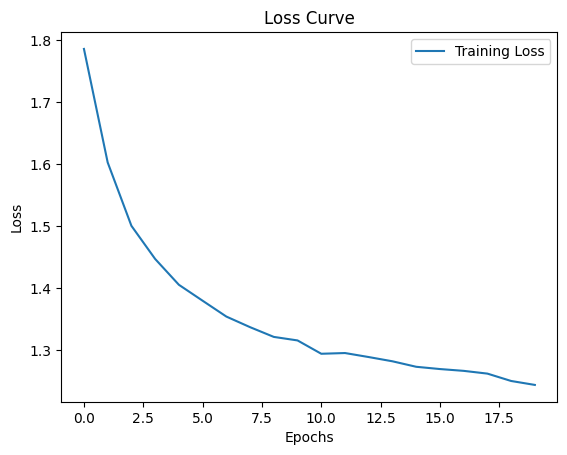

In [15]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label = "Training Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()  
